<a href="https://www.kaggle.com/code/kiroyoussef/capstone-preprocessing?scriptVersionId=151184318" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install fslpy ants nipype SimpleITK nilearn -U imageio==2.27 git+https://github.com/miykael/gif_your_nifti # nifti to gif 

  Cloning https://github.com/miykael/gif_your_nifti to /tmp/pip-req-build-3oocs912
  Running command git clone --filter=blob:none --quiet https://github.com/miykael/gif_your_nifti /tmp/pip-req-build-3oocs912
  Resolved https://github.com/miykael/gif_your_nifti to commit fc21f44a57d04a6ae471ba4be6da0f904d830669
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nibabel as nib
import matplotlib.pyplot as plt
import subprocess
import shutil
from scipy.ndimage import gaussian_filter
from skimage.exposure import equalize_adapthist
import ants
from os.path import join as opj
import nilearn
from nipype import Workflow, Node, MapNode
from nipype.interfaces.ants import ApplyTransforms
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.fsl import Info
import math
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
# import gif_your_nifti.core as gif2nif

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fmri-brain-dynamics-during-flow-experiences/README
/kaggle/input/fmri-brain-dynamics-during-flow-experiences/dataset_description.json
/kaggle/input/fmri-brain-dynamics-during-flow-experiences/participants.json
/kaggle/input/fmri-brain-dynamics-during-flow-experiences/participants.tsv
/kaggle/input/fmri-brain-dynamics-during-flow-experiences/sub-012/sub-012_scans.json
/kaggle/input/fmri-brain-dynamics-during-flow-experiences/sub-012/sub-012_scans.tsv
/kaggle/input/fmri-brain-dynamics-during-flow-experiences/sub-012/func/sub-012_task-game_run-01_events.json
/kaggle/input/fmri-brain-dynamics-during-flow-experiences/sub-012/func/sub-012_task-game_run-03_events.tsv
/kaggle/input/fmri-brain-dynamics-during-flow-experiences/sub-012/func/sub-012_task-game_run-01_bold.json
/kaggle/input/fmri-brain-dynamics-during-flow-experiences/sub-012/func/sub-012_task-game_run-03_bold_defaced.nii
/kaggle/input/fmri-brain-dynamics-during-flow-experiences/sub-012/func/sub-012_task-game_run-01_bo

In [3]:
TRAIN_DATASET_PATH = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'
TEMPLATE_T1 = '/kaggle/input/normalization-template/MNI152_T1_1mm.nii'
TEMPLATE_T2 = '/kaggle/input/normalization-template/MNI152_T2_1mm.nii'
# Define file paths
# input_path = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_030/BraTS20_Training_030_t1.nii'
input_path ='/kaggle/input/fmri-brain-dynamics-during-flow-experiences/sub-008/anat/sub-008_T1w_defaced.nii'
output_directory = '/kaggle/working/'
output_path = os.path.join(output_directory, 'my_betted_structural.nii.gz')

Processed scan saved to /kaggle/working/


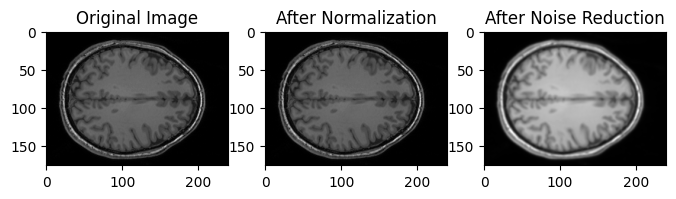

In [4]:
# Load the NIfTI image
img = nib.load(input_path)
data = img.get_fdata()
# Display the original image
plt.figure(figsize=(8, 8))
plt.subplot(131)
plt.imshow(data[:, :, data.shape[2] // 2], cmap='gray')
plt.title('Original Image')

# Step 1: Normalize to Range [-1, 1]
normalized_data = np.zeros(data.shape)
for slice_idx in range(data.shape[2]):
    slice = data[:, :, slice_idx]
    min_val = np.min(slice)
    max_val = np.max(slice)

    # Check if the minimum and maximum values are the same
    if min_val == max_val:
        # If all values are the same, set all to -1 or 1
        normalized_slice = np.full_like(slice, -1 if min_val < 0 else 1)
    else:
        # Normalize the slice to the range [-1, 1]
        normalized_slice = 2 * ((slice - min_val) / (max_val - min_val)) - 1

    normalized_data[:, :, slice_idx] = normalized_slice

# Step 2: Adaptive Histogram Normalization
normalized_data_after_histogram = np.zeros(data.shape)
for slice_idx in range(data.shape[2]):
    normalized_slice = equalize_adapthist(normalized_data[:, :, slice_idx], clip_limit=0.03)
    normalized_data_after_histogram[:, :, slice_idx] = normalized_slice

    
# Display the image after normalization
plt.subplot(132)
plt.imshow(normalized_data[:, :, data.shape[2] // 2], cmap='gray')
plt.title('After Normalization')

# Step 2: Noise Reduction (Gaussian Filter)
smoothed_data = gaussian_filter(normalized_data, sigma=1.0)

# Display the image after noise reduction
plt.subplot(133)
plt.imshow(smoothed_data[:, :, data.shape[2] // 2], cmap='gray')
plt.title('After Noise Reduction')

# Create a new NIfTI image with the processed data
output_img = nib.Nifti1Image(smoothed_data, img.affine)
nib.save(output_img, output_directory)

# Save the figure with all three images
plt.savefig('processed_images.png')

print(f"Processed scan saved to {output_directory}")

In [5]:
from nilearn.datasets import (
    load_mni152_template,
    load_sample_motor_activation_image,
)

template = load_mni152_template(resolution=1)

# Load your structural image
structural_img = output_img
# load_sample_motor_activation_image()

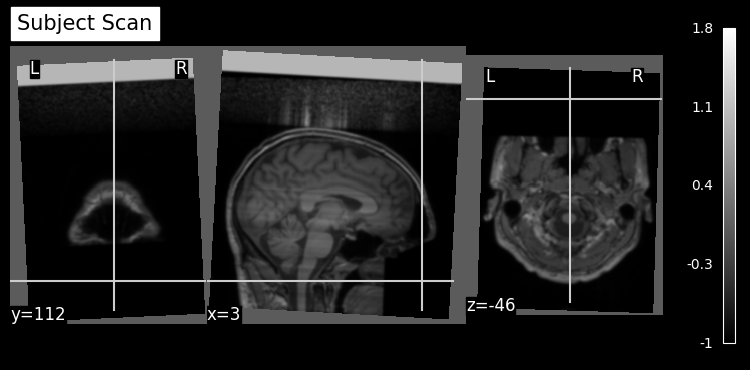

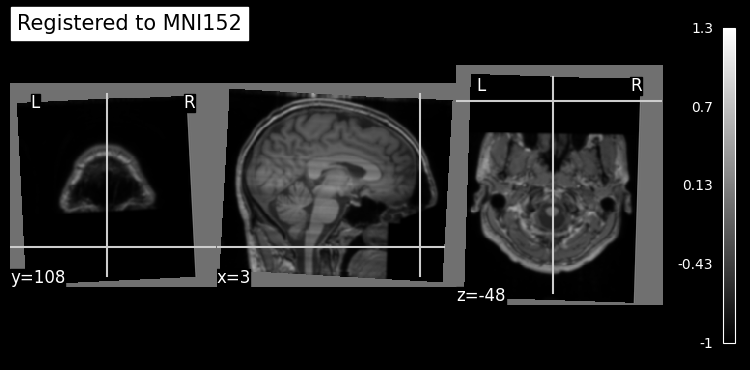

In [6]:
import SimpleITK as sitk
from nilearn import plotting

# Convert nibabel images to SimpleITK images
sitk_template = sitk.GetImageFromArray(template.get_fdata())
sitk_scan = sitk.GetImageFromArray(structural_img.get_fdata())

# Choose and configure a registration method (e.g., rigid)
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMeanSquares()
registration_method.SetOptimizerAsRegularStepGradientDescent(learningRate=0.1, minStep=1e-4, numberOfIterations=100)
# registration_method.SetOptimizerScalesFromPhysicalShift()

transform = registration_method.Execute(sitk_template, sitk_scan)
registered_scan = sitk.Resample(sitk_scan, sitk_template, transform)
registered_scan_data = sitk.GetArrayFromImage(registered_scan)
registered_scan_nifti = nib.Nifti1Image(registered_scan_data, structural_img.affine)

nib.save(registered_scan_nifti, output_directory)

plotting.plot_anat(structural_img, title='Subject Scan', display_mode='ortho', cut_coords=None, colorbar=True)
plotting.plot_anat(registered_scan_nifti, title='Registered to MNI152', display_mode='ortho', cut_coords=None, colorbar=True)

plotting.show()

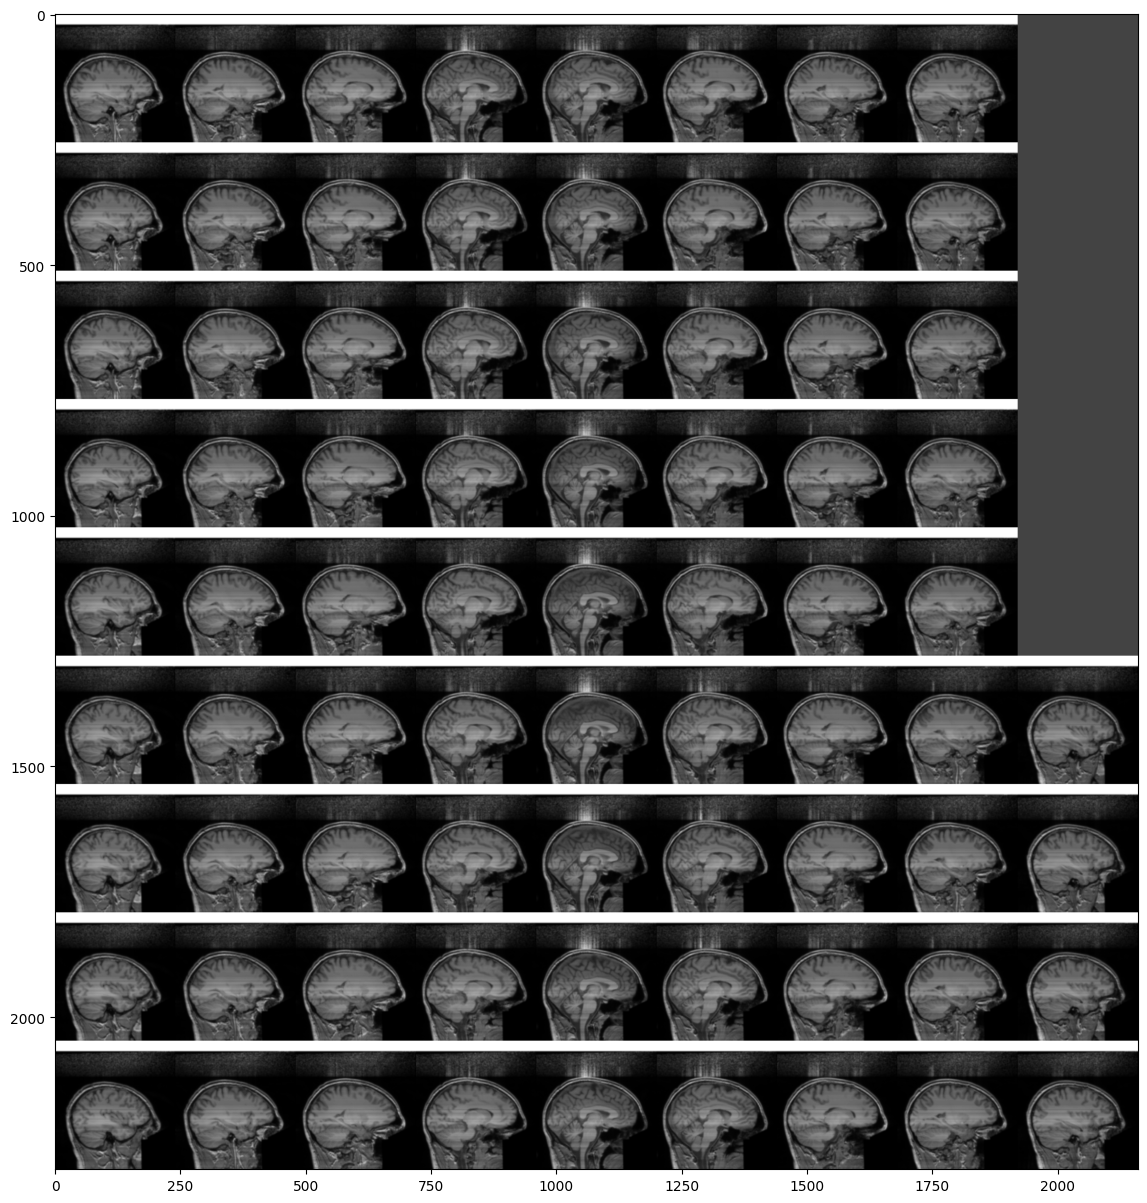

In [7]:
from nilearn.image import resample_to_img
 
# registered_scan_nifti = nib.load('/kaggle/working/registered_scan.nii')    
# Get the image data
data = structural_img.get_fdata()

fig, ax1 = plt.subplots(1, 1, figsize=(15, 15))
ax1.imshow(rotate(montage(data[50:-50, :, :]), 90, resize=True), cmap='gray')


# Resample to the template
resampled_stat_img = resample_to_img(structural_img, template, interpolation='linear')

Shape comparison:
- Original t-map image shape : (176, 240, 256)
- Resampled t-map image shape: (197, 233, 189)
- Template image shape       : (197, 233, 189)

Affine comparison:
- Original t-map image affine :
 [[ 9.98367667e-01  3.23775969e-02 -4.71232086e-02 -8.80126038e+01]
 [-2.97464337e-02  9.98015106e-01  5.55068478e-02 -9.65642700e+01]
 [ 4.88270186e-02 -5.40143065e-02  9.97345686e-01 -7.66626740e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
- Resampled t-map image affine:
 [[   1.    0.    0.  -98.]
 [   0.    1.    0. -134.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
- Template image affine       :
 [[   1.    0.    0.  -98.]
 [   0.    1.    0. -134.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]



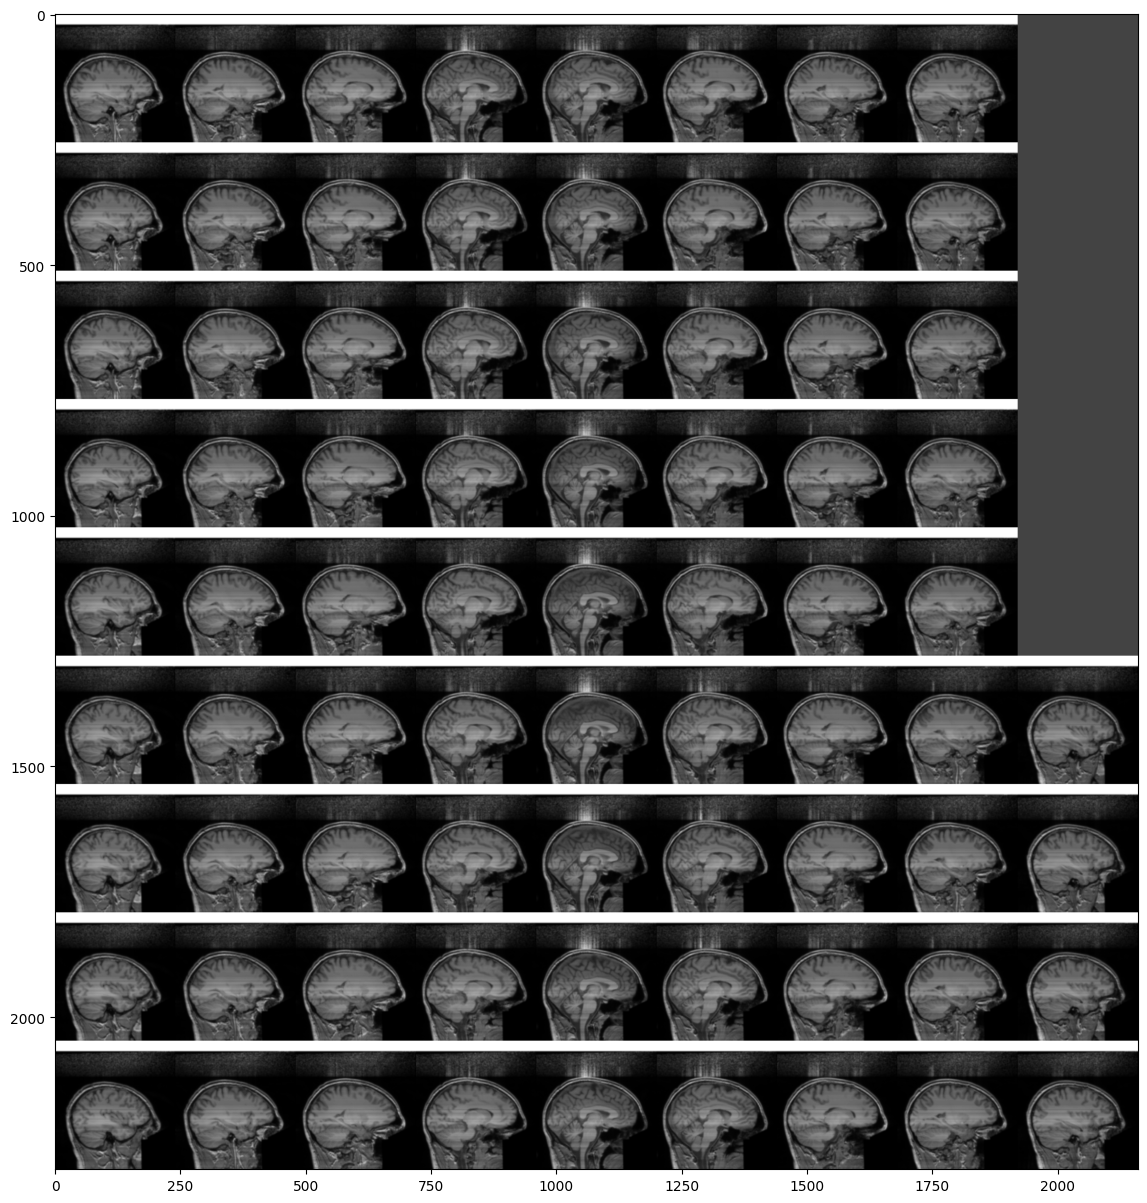

In [8]:
# First load the original t-map in memory:
from nilearn.image import load_img

tmap_img = load_img(structural_img)

# Get the image data
data = tmap_img.get_fdata()

fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(data[50:-50,:,:]), 90, resize=True), cmap ='gray')


original_shape = tmap_img.shape
original_affine = tmap_img.affine

resampled_shape = resampled_stat_img.shape
resampled_affine = resampled_stat_img.affine

template_img = load_img(template)
template_shape = template_img.shape
template_affine = template_img.affine
print(
    f"""Shape comparison:
- Original t-map image shape : {original_shape}
- Resampled t-map image shape: {resampled_shape}
- Template image shape       : {template_shape}
"""
)

print(
    f"""Affine comparison:
- Original t-map image affine :
 {original_affine}
- Resampled t-map image affine:
 {resampled_affine}
- Template image affine       :
 {template_affine}
"""
)

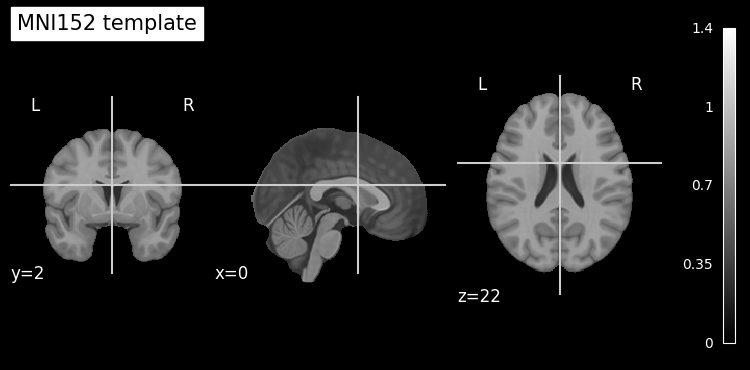

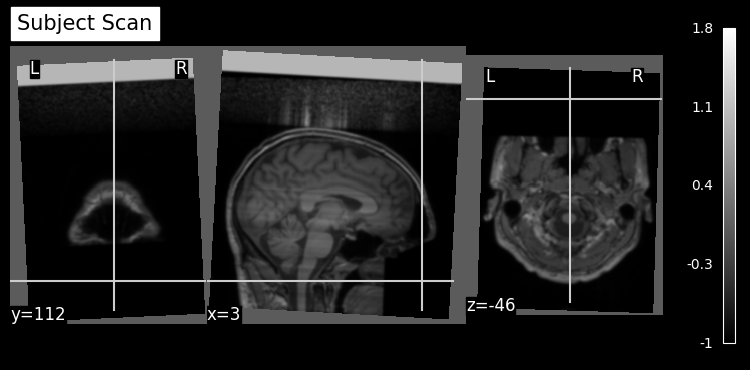

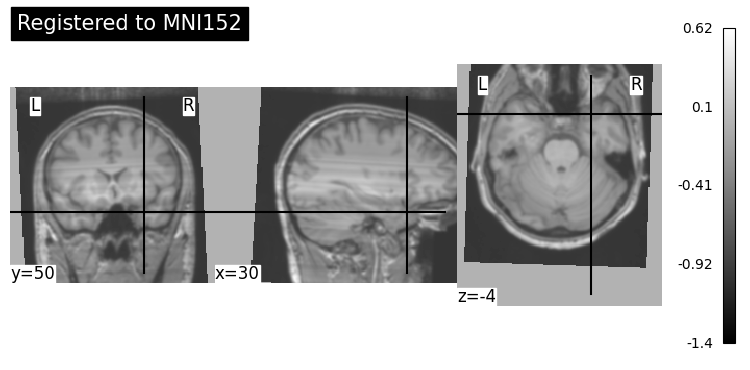

In [9]:
plotting.plot_anat(template, title='MNI152 template', display_mode='ortho', cut_coords=None, colorbar=True)
plotting.plot_anat(structural_img, title='Subject Scan', display_mode='ortho', cut_coords=None, colorbar=True)
plotting.plot_anat(resampled_stat_img, title='Registered to MNI152', display_mode='ortho', cut_coords=None, colorbar=True)
plotting.show()